In [ ]:
# Notebook I Used to Display the Results from "shadowgraphy_raytrace_multiprocess.py"

In [ ]:
# %matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np

import particle_tracker as pt
import ray_transfer_matrix as rtm

yt : [INFO     ] 2025-11-24 13:39:39,824 Parameters: current_time              = 1.0532564210672338e-08
yt : [INFO     ] 2025-11-24 13:39:39,825 Parameters: domain_dimensions         = [384 496 384]
yt : [INFO     ] 2025-11-24 13:39:39,825 Parameters: domain_left_edge          = [-0.8   -0.075 -0.8  ]
yt : [INFO     ] 2025-11-24 13:39:39,825 Parameters: domain_right_edge         = [0.8 2.  0.8]
yt : [INFO     ] 2025-11-24 13:39:39,825 Parameters: cosmological_simulation   = 0


{'num_photons': '1000000', 'beam_size': '0.012', 'divergence': '0', 'flash_file': '~/shared/simulations/FLASH_MagShockZ3D-Trantham_2024-11/MagShockZ_hdf5_chk_0028', 'scaling_factor': '1.0', 'num_processors': '32', 'timestamp': '1764019414.3802066'}


yt : [INFO     ] 2025-11-24 13:39:41,984 xlim = -0.800000 0.800000
yt : [INFO     ] 2025-11-24 13:39:41,985 ylim = -0.075000 2.000000
yt : [INFO     ] 2025-11-24 13:39:41,986 xlim = -0.800000 0.800000
yt : [INFO     ] 2025-11-24 13:39:41,986 ylim = -0.075000 2.000000
yt : [INFO     ] 2025-11-24 13:39:41,987 Making a fixed resolution buffer of (('flash', 'edens')) 800 by 800



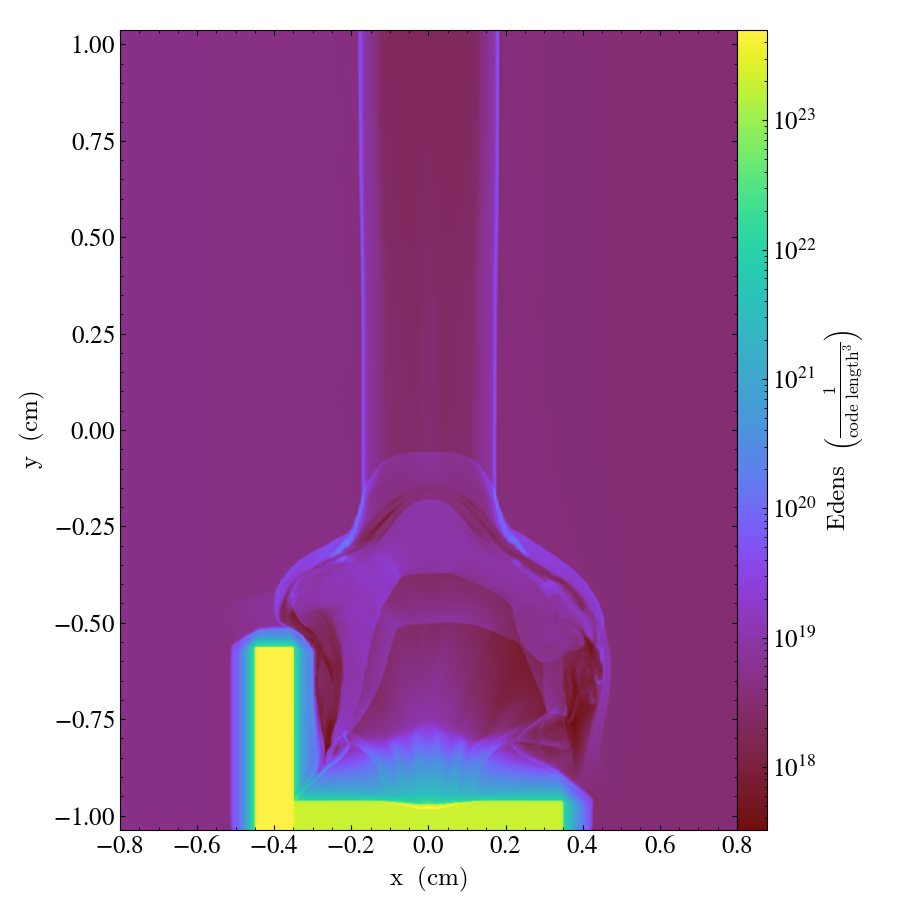

In [3]:
# Get data
import yt.units

ray_trace_dir = '1.e+06_rays_1.0_scaling_0_div'

metadata = {}
raytrace_metadata = ray_trace_dir + '/metadata.txt'
with open(raytrace_metadata, 'r') as f:
    metadata_lines = f.readlines()
    for line in metadata_lines:
        key, value = line.strip().split(': ')
        metadata[key] = value

print(metadata)

ds = yt.load(metadata["flash_file"])

def make_electron_number_density(field, data):
    N_A = yt.units.yt_array.YTQuantity(6.02214076e23, "1/mol")
    proton_mass = yt.units.yt_array.YTQuantity(1.6726219e-24, 'g')
    electron_number_density = N_A*data["flash","dens"]*data["flash","ye"]/proton_mass
    return electron_number_density
ds.add_field(("flash", "edens"), function=make_electron_number_density, units="1/code_length**3",sampling_type="cell") # same here

sl = yt.SlicePlot(ds, 'z', ('flash','edens'))
sl.show()

In [4]:
level = 0
dims = ds.domain_dimensions * ds.refine_by**level

# We construct an object that describes the data region and structure we want
# In this case, we want all data up to the maximum "level" of refinement
# across the entire simulation volume.  Higher levels than this will not
# contribute to our covering grid.

all_data = ds.covering_grid(
    level,
    left_edge=ds.domain_left_edge,
    dims=dims,
    # And any fields to preload (this is optional!)
)

# scale_factor = 1e-1 # this is nonphysical! This is simply a parameter that we tune in order to get shadowgraph images that match the experimental results. 
scale_factor = 1.0

n = all_data['flash','edens'][:,:,:].value*1e6 # multiply by 1e6 to get it in m^-3
n*=scale_factor

# Make sure that this is in meters, divide by 100 b/c all_data is in cgs

x = all_data['flash','x'][:,0,0].value/100
y = all_data['flash','y'][0,:,0].value/100 # 0.005 originally subtracted to center beam in y-dir
z = all_data['flash','z'][0,0,:].value/100

print(len(x), len(y), len(z))

x -= (x.max()+x.min())/2
y -= (y.max()+y.min())/2
y += 0.001
z -= (z.max()+z.min())/2

384 496 384


In [5]:
# rudimentary setup for labeling rays.npy with scale factor
scale_suffix = ''
factor_order = int(np.floor(np.log10(scale_factor)))
if factor_order > 0:
    scale_suffix = f'_p{str(factor_order)}'
elif factor_order < 0:
    scale_suffix = f'_m{str(factor_order)[1:]}'

In [ ]:
rf = np.load(f"{ray_trace_dir}/ray_output.npy")
beam_size = float(metadata["beam_size"])
photons = int(metadata["num_photons"])

det_size = 2*float(metadata['beam_size'])*10**3 # 10^3 to convert into mm
lens_rad=25
length=400
fp=0

sh = rtm.Shadowgraphy(r0=rf, focal_plane=fp, L=length, R=lens_rad, Lx=det_size, Ly=det_size)
sh.solve()
#lionz = rtm.LIONZ_approx()

lsc = rtm.Schlieren_LF(r0=rf, focal_plane=fp, L=length, R=lens_rad, Lx=det_size, Ly=det_size)
lsc.solve()
lsc.histogram(bin_scale=1)
sh.histogram(bin_scale=1)
# try plotting histogram

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(2574, 3448))

focal plane: 7.979166666666666


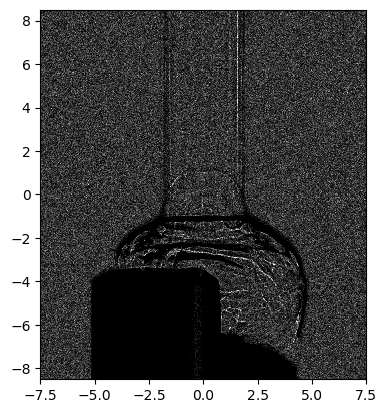

In [11]:
# define LIONZ optical system
focal_plane = 1e3*(z.max()-z.min())/2 #  midplane of simulation in mm

print("focal plane:", focal_plane)


offset_mm = 2 # offset for focusing
Lens_FL = 400
total_dist = 450+3600 # distance from target to first image plane
if Lens_FL == 400:
    d1= 450
elif Lens_FL == 500:
    d1 = 584.3

d2 =total_dist-d1
Lens_Rad = .5*75/2 # radius of lens
# Lx (int, optional): Detector size in x. Defaults to 18.
# Ly (float, optional): Detector size in y. Defaults to 13.5.
sh = rtm.LIONZ_approx(r0 = rf, Lx = 15, Ly = 17, focal_plane = focal_plane+offset_mm, L=Lens_FL, R=Lens_Rad) # must center grid
sh.solve(d1=d1,d2=d2)
sh.histogram(bin_scale = 7)
# plot
fig, axs = plt.subplots()
cm='gray'
#clim=[0,15]

vmin=np.percentile(sh.H, 5)
vmax=np.percentile(sh.H,90)

clim=(0,vmax*3) # trial and error
sh.plot(axs, cmap=cm, clim=clim)


#offset_mm = 0
#sh_focused = rtm.LIONZ_approx(r0 = rf, Lx = 15, Ly = 17, focal_plane = 0, L=Lens_FL, R=Lens_Rad)
#sh_focused.solve(d1=d1,d2=d2)
#sh_focused.histogram(bin_scale = 7)

plt.savefig(f'{ray_trace_dir}/sh_fp_{np.round(focal_plane+offset_mm,2)}.png', bbox_inches='tight')

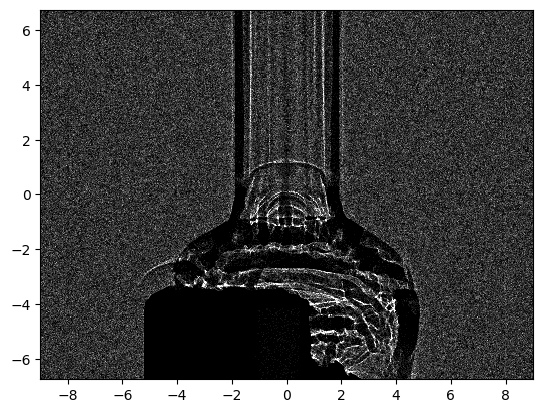

In [ ]:
sh = rtm.LIONZ_approx(r0=rf) # must center grid
sh.solve(d1=d1,d2=d2)
sh.histogram(bin_scale = 7)

# plot
fig, axs = plt.subplots()
cm='gray'
vmin=np.percentile(sh.H, 5)
vmax=np.percentile(sh.H,95)
clim=(0,vmax*2.5) # trial and error
sh.plot(axs, cmap=cm, clim=clim)

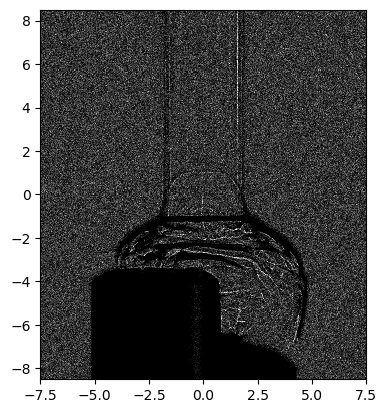

In [ ]:
from matplotlib.colors import LogNorm

Lens_FL = 400
Lens_Rad = .5*75/2 # radius of lens

total_dist = 450+3600 # distance from target to first image plane
if Lens_FL == 400:
    d1= 450
elif Lens_FL == 500:
    d1 = 584.3

d2 =total_dist-d1

sh = rtm.LIONZ_approx(r0 = rf, Lx = 15, Ly = 17, focal_plane = 10, L=Lens_FL, R=Lens_Rad) # must center grid
sh.solve(d1=d1,d2=d2)

sh.histogram(bin_scale = 7)
# plot
fig, axs = plt.subplots()
cm='gray'
#clim=[0,15]

vmin=np.percentile(sh.H, 5)
vmax=np.percentile(sh.H,95)
clim=(0,vmax*2.5) # trial and error
sh.plot(axs, cmap=cm, clim=clim)


In [ ]:
#time=ds.current_time.to_value('ns')
#
#vmin=np.percentile(lsc.H, 5)
#vmax=np.percentile(lsc.H,95)
##clim=(0,vmax*3) # trial and error
#
#fig, ax = plt.subplots()
##ax.imshow(lsc.H, interpolation='nearest', clim=clim, origin='lower', cmap='grey',
##                extent=[sh.xedges[-1], lsc.xedges[0], lsc.yedges[-1], lsc.yedges[0]])
#
#ax.imshow(lsc.H, interpolation='nearest', origin='lower', cmap='grey',
#                extent=[sh.xedges[-1], lsc.xedges[0], lsc.yedges[-1], lsc.yedges[0]])
#
#ax.invert_xaxis()
#ax.invert_yaxis()
#ax.set_xlabel('x (mm)')
#ax.set_ylabel('y (mm)')
#ax.set_title(f'FLASH Shadowgraph, t={round(time, 2)}ns')
#print(os.getcwd())
#plt.savefig(f'./particle_tracking/shadowgraphs/sh_{file_num}_{photons}.png', bbox_inches='tight')